In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.gpt2_generation import GPT2GenerationAnonymization
from models.gpt2_model import PretrainedGPT2TextInfilling
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)
anon_gpt2_config = yaml.load(open("configs/gpt2_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

In [7]:
anon_gpt2_config["model_version"] = 21
bert_large_model_config["model_version"] = 15

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на анонимизированном с помощью справочников тренировочном наборе данных i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    7. Version 6 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    8. Version 7 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра
    9. Version 8 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (12) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2006
    10. Version 9 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, (12) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2014
    11. Version 10 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра (окно 256 токенов)
    12. Version 11 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра (окно 256 токенов)
    13. Version 12 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2014 без учёта регистра, (20) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2014
    14. Version 13 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2006 без учёта регистра, (20) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2006
    15. Version 14 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2014 без учёта регистра, (21) GPT2 обучен с помощью RL
    16. Version 15 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2006 без учёта регистра, (21) GPT2 обучен с помощью RL
    17. Version 16 --- бесмысленный эксперимент: заменить в тренировочном наборе данных личные сущности на случайные из валидационного набора данных (на примере i2b2 2014, train и validate поменяли местами)
    18. Version 17 --- обученная на тренировочном наборе данных i2b2 2006, анонимизированном с помощью именованных сущностей из набора данных i2b2 2014, без учёта регистра 

### Этап 1: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [ ]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
model_reader = TensorBoardReader(Path(anon_gpt2_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = model_reader.get_ckpt_path(anon_gpt2_config["model_version"])
text_infill_model = PretrainedGPT2TextInfilling.load_from_checkpoint(path_to_checkpoint, strict=False).to("cuda:0")
text_infill_model.eval()
anonymization = GPT2GenerationAnonymization(text_infill_model,
                                            label2type=lambda x: MaskEntityType[x.upper()],
                                            mask_types=list(MaskEntityType), **anon_gpt2_config)

In [9]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"], 
                               anonymization=anonymization, device='cpu',
                               **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Start data tokenization


  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [10]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path(7))

In [11]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9770776033401489
     test_precision         0.9770776033401489
       test_recall          0.6585160493850708
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.6585160493850708,
  'test_precision': 0.9770776033401489,
  'test_f1': 0.9770776033401489}]

  0%|          | 0/855 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NAME     0.8528    0.8545    0.8537     37825
  PROFESSION     0.7708    0.1095    0.1917       338
    LOCATION     0.6874    0.0659    0.1203      7373
         AGE     0.6489    0.7753    0.7065      1175
        DATE     0.5278    0.7319    0.6133     19773
          ID     0.2271    0.1180    0.1553      4440
     CONTACT     0.3327    0.1361    0.1932      3917

   micro avg     0.6904    0.6585    0.6741     74841
   macro avg     0.5782    0.3987    0.4048     74841
weighted avg     0.6827    0.6585    0.6366     74841



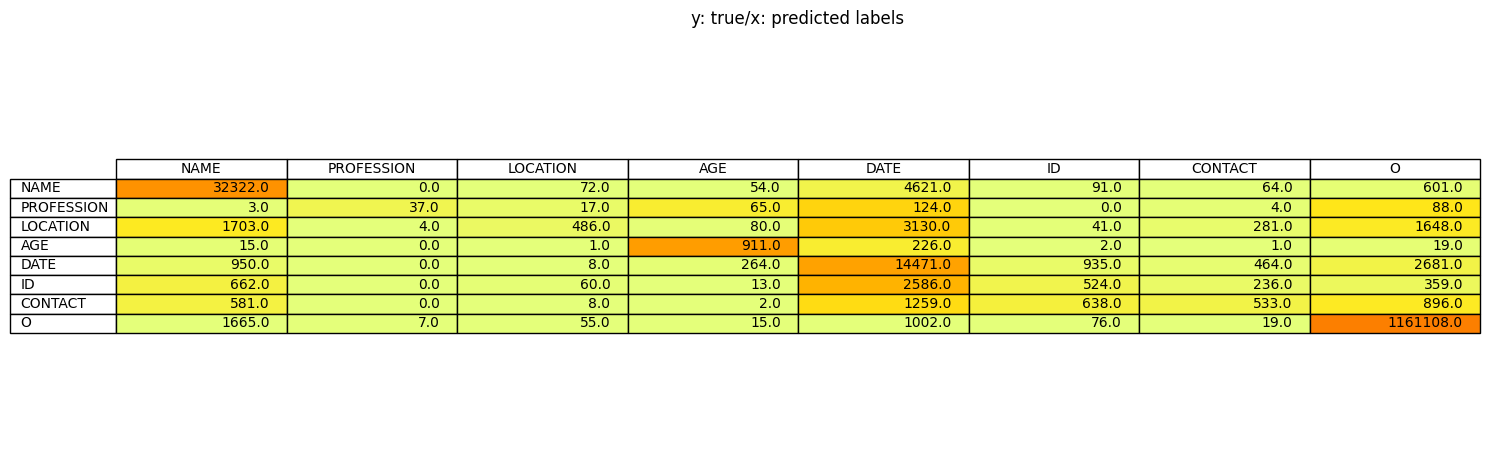

Wrongly predicted examples:
_____ Record 195-03:1196 _____
| Sentence:    | - 0. 09 ng / ml | 1964 | 00 : 17 hematology complete blood count wbc 8. 4 4. 5 - 11. 0 th / cmm | 73   | 23 : 09 13. 6 ( h ) | 1976 | 03 : 43 rbc 4. 38l 4. 50 - 5. 90 mil / cm | 78   | 23 : 09 4. 38 ( l ) | 1976 | 23 : 09 hgb 11. 9l 13. 5 - 17. 5 gm / dl | 78   | 23 : 09 11. 9 |
| True labels: | O               | DATE | O                                                                      | DATE | O                   | DATE | O                                         | DATE | O                   | DATE | O                                        | DATE | O             |
| Sentence:    | - 0. 09 ng / ml 1964 00 : 17 hematology complete blood count wbc 8. 4 4. 5 - 11. 0 th / cmm 73 23 : 09 13. 6 ( h ) | 1976 | 03 : 43 rbc 4. 38l 4. 50 - 5. 90 mil / cm 78 23 : 09 4. 38 ( l ) | 1976 | 23 : 09 hgb 11. 9l 13. 5 - 17. 5 gm / dl 78 23 : 09 11. 9 |
| Pred labels: | O                                                      

In [12]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [13]:
# import importlib
# ner_metrics = importlib.import_module('utils.ner_metrics')
# ner_metrics = importlib.reload(ner_metrics)

In [14]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 201-02:2019 _____
| Sentence:    | _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ | fredrick | , md, msc | franklyn austin | department of medicine pager # | 1897    |
| True labels: | O                                         | NAME     | O         | LOCATION        | O                              | CONTACT |
| Sentence:    | _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ | fredrick | , md, msc | franklyn | austin   | department of medicine pager # | 1897 |
| Pred labels: | O                                         | NAME     | O         | NAME     | LOCATION | O                              | ID   |
_____ Record 347-04:1219 _____
| Sentence:    | _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ | john | md, mba | 1940     | neurology |
| True labels: | O                                     | NAME | O       | LOCATION | O         |
| Sentence:    | _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ | john | md, mba | 1940 | neurology |
| Pred labels: | O                       

['110-03:716',
 '110-03:732',
 '110-03:733',
 '110-03:737',
 '110-03:738',
 '110-03:741',
 '110-03:742',
 '110-03:743',
 '110-03:744',
 '110-03:745',
 '110-03:746',
 '110-03:747',
 '110-03:748',
 '110-03:749',
 '110-03:750',
 '110-03:751',
 '110-03:752',
 '110-03:753',
 '110-03:754',
 '110-03:755',
 '110-03:756',
 '110-03:757',
 '110-03:758',
 '110-03:759',
 '110-03:760',
 '110-03:761',
 '110-03:762',
 '110-03:763',
 '110-03:764',
 '110-03:765',
 '110-03:766',
 '110-03:767',
 '110-03:768',
 '111-01:0',
 '111-02:0',
 '111-03:0',
 '112-01:0',
 '112-01:297',
 '112-01:357',
 '112-02:0',
 '112-02:600',
 '112-02:626',
 '112-02:627',
 '112-02:628',
 '112-02:629',
 '112-02:631',
 '112-02:632',
 '112-02:633',
 '112-02:634',
 '112-02:635',
 '112-02:636',
 '112-02:637',
 '112-02:640',
 '112-02:641',
 '112-02:642',
 '112-02:643',
 '112-02:647',
 '112-02:648',
 '112-02:649',
 '112-02:650',
 '112-02:651',
 '112-02:652',
 '112-02:653',
 '112-02:654',
 '112-02:655',
 '112-03:0',
 '112-03:174',
 '112-0

In [15]:
stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 260-01:598 _____
| Sentence:    | ( note ) reference range : random urine < 2. 0 mg / dl 24 hr urine < 300 mg / 24 hr allergies penicillins - rash : | 48   | . social history married. lives with wife. sexually active, usually needs viagra. | 1952       | , | 1909       | , worked for | 1800     | , now | 1943     | . then | 1943     | . now about to start job as | 1950       | . review of systems general - neg eyes - see above ears - ext ear infs from swimming, wears wax earplugs |
| True labels: | O                                                                                                                  | DATE | O                                                                                 | PROFESSION | O | PROFESSION | O            | LOCATION | O     | LOCATION | O      | LOCATION | O                           | PROFESSION | O                                                                                                        |
| 

['114-01:364',
 '114-01:418',
 '114-03:361',
 '114-04:601',
 '115-04:0',
 '117-02:657',
 '117-02:715',
 '130-01:356',
 '130-01:414',
 '130-02:119',
 '130-02:478',
 '130-02:538',
 '130-02:59',
 '130-03:538',
 '130-03:598',
 '130-04:1016',
 '130-04:1076',
 '130-05:242',
 '130-05:301',
 '131-01:1135',
 '131-01:1195',
 '131-02:1553',
 '131-02:1613',
 '131-03:418',
 '131-03:477',
 '131-04:238',
 '132-01:419',
 '132-01:479',
 '132-04:535',
 '132-04:594',
 '134-01:180',
 '134-02:0',
 '134-02:60',
 '134-03:894',
 '134-03:954',
 '134-05:655',
 '134-05:715',
 '135-04:662',
 '161-01:0',
 '161-01:58',
 '161-04:354',
 '161-04:413',
 '161-05:238',
 '161-05:299',
 '162-04:361',
 '163-01:478',
 '163-03:599',
 '165-04:897',
 '166-03:658',
 '191-01:299',
 '191-01:359',
 '192-03:240',
 '193-01:122',
 '193-02:116',
 '193-02:175',
 '193-05:0',
 '194-01:656',
 '194-02:1079',
 '194-02:1137',
 '194-03:1013',
 '194-03:953',
 '197-04:420',
 '197-05:298',
 '198-03:1015',
 '198-03:1074',
 '198-04:1253',
 '198-04:

**Вывод:**  
В целом все метки предсказываются с точностью, близкой к аналогичной у первоначальных сущностей. Самое низкое качество распознавания у модели оказалось для класса 'LOCATION', предположительно, из-за слишком длинных названий больниц в используемом справочнике. Однако в первых версиях генератора синтетических данных присутствовали проблемы с меткой 'CONTACT'. Основная трудность для модели заключалась в предсказании номеров телефонов, если их генерация использовала российский стиль их написания. Тогда модель определяла его, как уникальный идентификатор. Проблема была решена сменной формата номера.  
  
Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы отлично от распространённого российского варианта.  
Запись **347-03**  
Original:  (121) 537-3484  
Russian format: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Russian format: +1 995 672-52-24  
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 2: Обучение NER на анонимизированных с помощью ILM наборе данных i2b2-2014

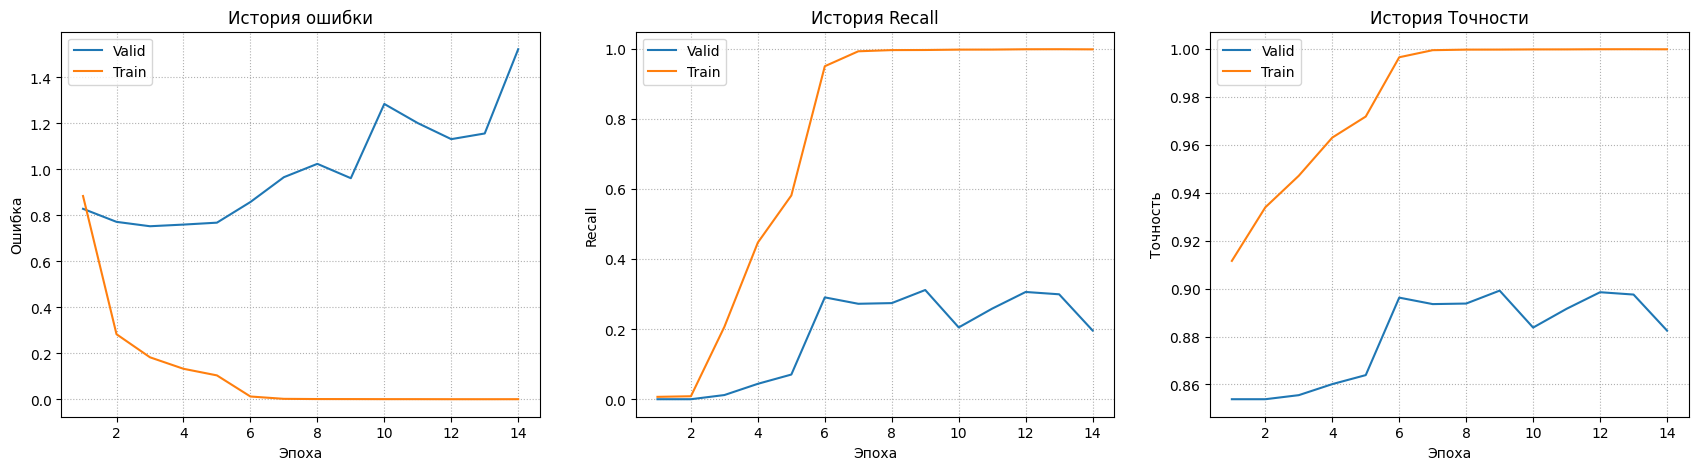

In [16]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(bert_large_model_config["model_version"])

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [17]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["train_data_path"], device='cpu', **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


In [18]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(bert_large_model_config["model_version"])
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [19]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9108464121818542
     test_precision         0.9108464121818542
       test_recall          0.3038099408149719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.3038099408149719,
  'test_precision': 0.9108464121818542,
  'test_f1': 0.9108464121818542}]

  0%|          | 0/1318 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NAME     0.9729    0.6178    0.7557     90628
  PROFESSION     0.0000    0.0000    0.0000       856
    LOCATION     0.2163    0.1656    0.1876     17333
         AGE     0.0000    0.0000    0.0000      2028
        DATE     0.8332    0.1210    0.2113     99979
          ID     0.2607    0.2422    0.2511     20030
     CONTACT     0.6857    0.0051    0.0100     18993

   micro avg     0.7292    0.3038    0.4289    249847
   macro avg     0.4241    0.1645    0.2022    249847
weighted avg     0.7744    0.3038    0.3926    249847



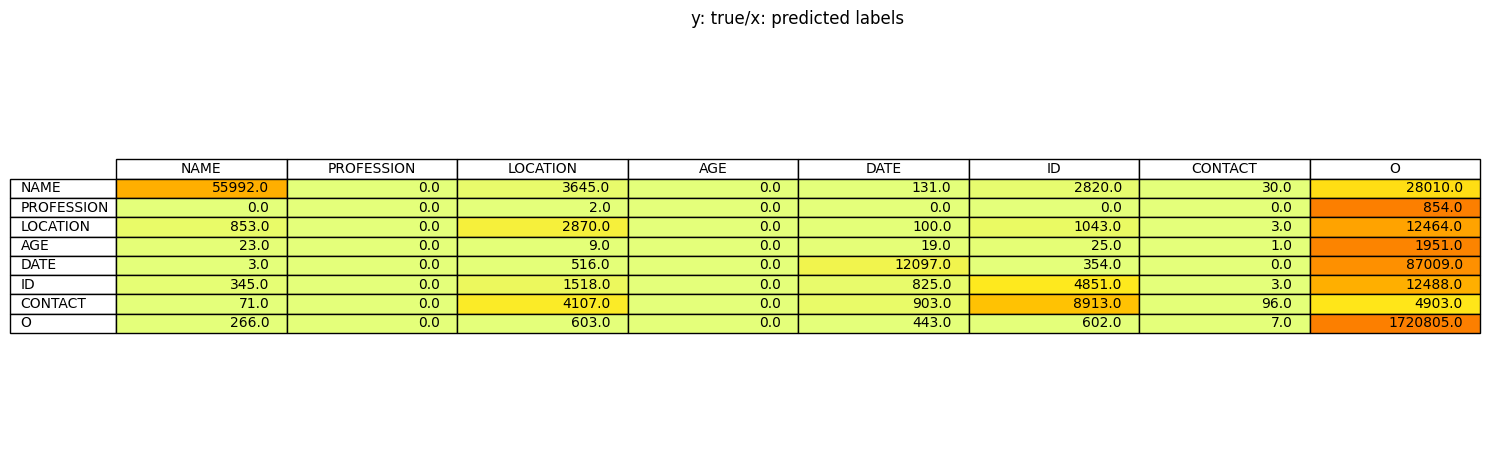

Wrongly predicted examples:
_____ Record 256-02:120 _____
| Sentence:    | in education and counseling of the patient and family. hpi : as you know, ms. | klein | is a | 74  | yo rh woman with history of htn, hyperlipidemia, cad s / p lad stent ( | 2144 | ), migraine, who was in her usoh until the afternoon of | 2 / 6 / 50 | when she experienced sudden onset of garbled speech and difficulty " expressing myself " while cooking lunch for she and her husband. this episode was accompanied shortly thereafter |
| True labels: | O                                                                             | NAME  | O    | AGE | O                                                                      | DATE | O                                                       | DATE       | O                                                                                                                                                                                     |
| Sentence:    | in education and co

In [20]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [21]:
stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 395-04:951 _____
| Sentence:    | morphine - nausea family history : father - died when patient was | 13 months | old mother - diabetes no know family history of malignancies or autoimmune disorders social history : divorced, lives alone, no children. used to work as a | paralegal  | for 42 years. retired. tobacco : 50 pack - year history ( stopped 20 years ago ) alcohol : none review of system : general : night sweats, weight loss - 1. 5 years. loosing approximately 0. 5 - 1 |
| True labels: | O                                                                 | AGE       | O                                                                                                                                                           | PROFESSION | O                                                                                                                                                                                                   |
| Sentence

['100-01:180',
 '100-03:180',
 '100-03:240',
 '102-03:240',
 '102-03:300',
 '105-01:418',
 '105-01:478',
 '106-01:600',
 '106-02:241',
 '106-02:300',
 '106-03:477',
 '106-03:537',
 '106-04:835',
 '106-04:894',
 '108-01:178',
 '108-01:238',
 '108-02:536',
 '108-02:595',
 '108-03:1073',
 '108-03:1133',
 '108-04:1018',
 '108-04:959',
 '120-01:120',
 '120-01:181',
 '120-02:0',
 '120-02:121',
 '120-02:180',
 '125-01:0',
 '125-01:60',
 '125-02:659',
 '125-02:718',
 '125-03:717',
 '126-01:720',
 '126-01:778',
 '126-02:356',
 '126-02:416',
 '126-05:655',
 '126-05:714',
 '127-03:240',
 '127-03:303',
 '127-04:481',
 '127-04:538',
 '127-05:656',
 '127-05:717',
 '128-01:60',
 '128-04:594',
 '128-05:478',
 '128-05:538',
 '129-05:651',
 '141-02:598',
 '141-02:657',
 '141-04:299',
 '142-01:235',
 '142-01:295',
 '142-02:240',
 '142-02:300',
 '142-03:419',
 '142-03:479',
 '142-04:180',
 '142-04:239',
 '144-04:60',
 '145-02:716',
 '145-02:774',
 '145-03:476',
 '145-04:1011',
 '145-04:952',
 '145-05:894'

In [22]:
stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:
_____ Record 177-04:3106 _____
| Sentence:    | _ _ _ | jocelyn t issa | md, mphil pager # | 61158   |
| True labels: | O     | NAME           | O                 | CONTACT |
| Sentence:    | _ _ _ | jocelyn t issa | md, mphil pager # | 61158 |
| Pred labels: | O     | NAME           | O                 | ID    |
_____ Record 104-03:2132 _____
| Sentence:    | . 7. prophylaxes. nexium ; on heparin post - event. | vincent a. xayavong | # | 13828   |
| True labels: | O                                                   | NAME                | O | CONTACT |
| Sentence:    | . 7. prophylaxes. nexium ; on heparin post - event. | vincent | a. xayavong # | 13828 |
| Pred labels: | O                                                   | ID      | O             | ID    |


['100-04:1007',
 '100-04:1046',
 '100-04:1047',
 '100-04:1049',
 '100-04:1050',
 '100-04:1051',
 '100-04:1053',
 '100-04:1054',
 '100-04:1055',
 '100-04:1056',
 '100-04:1058',
 '100-04:1059',
 '100-04:1060',
 '100-04:1061',
 '100-04:1062',
 '100-04:1063',
 '100-04:1064',
 '100-04:1066',
 '100-04:1067',
 '100-04:1069',
 '100-04:1070',
 '100-04:1071',
 '100-04:1072',
 '100-04:1073',
 '100-04:1074',
 '100-04:1075',
 '100-04:1077',
 '100-04:1078',
 '100-04:1079',
 '100-04:1080',
 '100-04:1081',
 '100-04:1082',
 '100-04:1083',
 '100-04:1084',
 '100-04:1085',
 '100-05:2635',
 '100-05:2693',
 '100-05:2694',
 '100-05:2697',
 '100-05:2698',
 '100-05:2704',
 '100-05:2705',
 '100-05:2706',
 '100-05:2707',
 '100-05:2708',
 '100-05:2709',
 '100-05:2710',
 '100-05:2711',
 '100-05:2712',
 '100-05:2713',
 '100-05:2715',
 '100-05:2717',
 '100-05:2718',
 '100-05:2719',
 '102-05:298',
 '102-05:351',
 '102-05:352',
 '102-05:353',
 '102-05:354',
 '102-05:355',
 '102-05:356',
 '102-05:358',
 '102-05:359',
 

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

### Этап 3: Обучение NER на анонимизированных с помошью ILM данных из набора данных i2b2-2006

In [23]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2006_data_config["validate_data_path"], device='cpu', **i2b2_2006_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2006_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [24]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1             0.899168074131012
     test_precision          0.899168074131012
       test_recall          0.3117777705192566
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.3117777705192566,
  'test_precision': 0.899168074131012,
  'test_f1': 0.899168074131012}]

  0%|          | 0/346 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NAME     0.9791    0.4864    0.6500     31938
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.3791    0.1506    0.2156      8085
         AGE     0.0000    0.0000    0.0000        10
        DATE     0.7066    0.0771    0.1390     21502
          ID     0.8030    0.4357    0.5649     11178
     CONTACT     0.9967    0.1027    0.1862      2921

   micro avg     0.8485    0.3118    0.4560     75634
   macro avg     0.5521    0.1789    0.2508     75634
weighted avg     0.8120    0.3118    0.4277     75634



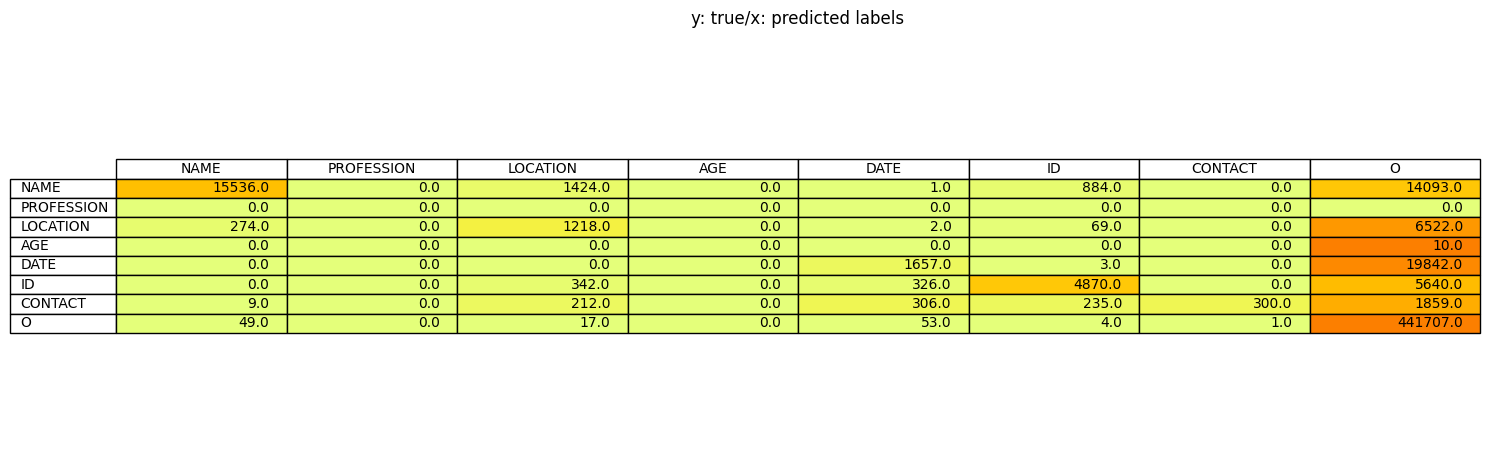

Wrongly predicted examples:
_____ Record 502:596 _____
| Sentence:    | t : | 06 / 13 | / 99 | ke9 | [ report _ end ] |
| True labels: | O   | DATE    | O    | ID  | O                |
| Sentence:    | t : 06 / 13 / 99 | ke9      | [ report _ end ] |
| Pred labels: | O                | LOCATION | O                |
_____ Record 617:1236 _____
| Sentence:    | : | 10 / 02 | / 98 [ report _ end ] |
| True labels: | O | DATE    | O                     |
| Sentence:    | : 10 / 02 / 98 [ report _ end ] |
| Pred labels: | O                               |
_____ Record 621:233 _____
| Sentence:    | , malpositioned. despite aggressive measures, he could not be stabilized. his family elected to change his current status dnr / dni and he passed away in their presence on the morning of | 06 / 15 | / 04. an autopsy was consented to and has been performed. again please see the medical chart for details of the hospital course. escription document : | 1 - 5733522 gdnvvu | tel dictated by : | koteru

In [25]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [26]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 541:1301 _____
| Sentence:    | drabelk kote | at | box memorial hospital nursing home | dr. | naabel scgach | dr. | bone | [ report _ end ] |
| True labels: | NAME         | O  | LOCATION                           | O   | NAME          | O   | NAME | O                |
| Sentence:    | drabelk | kote at | box memorial | hospital nursing home dr. | naabel | scgach dr. | bone | [ report _ end ] |
| Pred labels: | NAME    | O       | LOCATION     | O                         | NAME   | O          | NAME | O                |
_____ Record 506:120 _____
| Sentence:    | the patient is a 65 year old male who sustained a small myocardial infarction first in 1978, with course thereafter including a coronary artery bypass graft by dr. | wierst | _ _ _ _ _ _ _ _ _ _ _ _ _ _ at | noughwell entanbon health | in 1986. in 1991 he presented with congestive heart failure and he underwent porcine aortic valve replacement. in the seven to eight months preceding ad

['111:0',
 '111:662',
 '111:720',
 '135:0',
 '151:0',
 '151:60',
 '168:0',
 '168:1257',
 '168:2208',
 '177:0',
 '177:119',
 '177:1373',
 '177:1433',
 '177:177',
 '185:0',
 '185:1253',
 '185:1306',
 '185:1307',
 '185:1309',
 '185:1313',
 '185:1314',
 '185:1317',
 '185:1318',
 '185:1319',
 '185:1320',
 '185:1321',
 '185:1322',
 '185:1323',
 '185:1325',
 '185:1326',
 '185:1327',
 '185:1329',
 '185:1332',
 '185:1333',
 '185:1334',
 '185:1336',
 '185:1337',
 '185:180',
 '185:240',
 '194:0',
 '194:120',
 '194:180',
 '194:595',
 '194:655',
 '202:0',
 '202:1373',
 '202:1433',
 '202:1552',
 '202:237',
 '202:297',
 '206:0',
 '214:0',
 '214:240',
 '214:420',
 '214:480',
 '220:0',
 '220:60',
 '233:0',
 '233:1137',
 '233:1197',
 '233:538',
 '233:598',
 '420:0',
 '420:302',
 '420:360',
 '420:60',
 '420:839',
 '422:0',
 '422:1310',
 '422:1370',
 '422:1610',
 '422:1670',
 '422:1694',
 '422:1696',
 '422:1697',
 '422:1698',
 '422:1701',
 '422:1702',
 '422:1703',
 '422:1705',
 '422:1706',
 '422:1707',
 '

In [27]:
stats.get_specific_failed_predictions('ID')

Wrongly predicted examples:
_____ Record 494:0 _____
| Sentence:    | 590407820 | elmvh    | 65611410 716738 | 6 / 16 | / 2002 12 : 00 : 00 am multiple trauma signed dis admission date : | 06 / 16 | / 2002 report status : signed discharge date : | 06 / 27 | / 2002 history of the present illness : this is a 57 - year - old male status post a motorcycle accident at approximately 35 miles per hour. he suffered a closed right medial condyle fracture and a closed left tibial pilon fracture. |
| True labels: | ID        | LOCATION | ID              | DATE   | O                                                                  | DATE    | O                                              | DATE    | O                                                                                                                                                                                                                                        |
| Sentence:    | 590407820 elmvh 65611410 | 716738 | 6 / 16 / 2002 

['111:0',
 '111:1197',
 '111:1257',
 '135:0',
 '135:1610',
 '135:1670',
 '135:1720',
 '135:1724',
 '135:1725',
 '135:1728',
 '135:1729',
 '135:1730',
 '135:1731',
 '151:0',
 '151:60',
 '151:777',
 '151:837',
 '151:866',
 '151:867',
 '151:868',
 '151:869',
 '151:870',
 '151:871',
 '151:872',
 '151:873',
 '151:874',
 '168:0',
 '168:2388',
 '168:2421',
 '168:2422',
 '168:2423',
 '168:2424',
 '168:2425',
 '168:2426',
 '168:2427',
 '168:2428',
 '168:2429',
 '168:2430',
 '168:2431',
 '168:2432',
 '168:2433',
 '168:2434',
 '168:2436',
 '168:2437',
 '168:2439',
 '177:0',
 '185:0',
 '185:1194',
 '185:1253',
 '194:0',
 '194:1969',
 '194:2028',
 '194:2029',
 '194:2030',
 '194:2031',
 '194:2032',
 '194:2033',
 '194:2034',
 '194:2035',
 '194:2036',
 '194:2037',
 '194:2038',
 '194:2039',
 '194:2042',
 '194:2043',
 '194:2044',
 '194:2045',
 '194:60',
 '202:0',
 '206:0',
 '206:715',
 '206:775',
 '206:832',
 '206:833',
 '206:837',
 '206:838',
 '206:840',
 '206:841',
 '206:842',
 '206:843',
 '214:0',
 '

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных: